# Initial data wrangling

In [1]:
# Import the libs
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
from iris_utils import mask_from_shape
from matplotlib import pyplot as plt
import dask.array as da
from dask.distributed import Client
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import os

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36625,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.50 GiB
Comm: tcp://127.0.0.1:40230,Total threads: 4
Dashboard: http://127.0.0.1:37044/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:35388,


Lets take a look at the EC-EARTH-LENS data.
What is the goal of this notebook?
- Look at anomalies for the 2018 summer? See what the percentiles are. Is it hot?
- How to deal with the ensemble? I guess we just pool it since we are interested in the variation anyway.
- Gävle is not fitting to look at in this data IMO. Resolution is too large. So this should be done with CORDEX I guess.

## Get a shapefile of Sweden

We use a shapefile of the region of interest for two purposes
- Something to plot the data agains.
- Create a mask which can be used for finer data selection. 

In [3]:
# This file contains shapes of most countries in the world.
# https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-boundary-lines/
fname = "/home/sm_erhol/data/ne_10_admin_0_countries/ne_10m_admin_0_countries.shp"

In [4]:
gdf = gpd.read_file(fname)

In [5]:
gdf.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,1,Peru,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


In [6]:
# Select Sweden.
region = gdf[gdf.SOVEREIGNT == "Sweden"].geometry

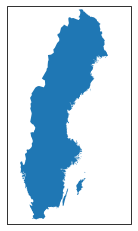

In [7]:
# We can submit the EPSG for SWEREF 99 TM to cartopy.
proj = ccrs.epsg(3006)
fig, ax = plt.subplots(subplot_kw={"projection": proj})
ax.add_geometries(region, ccrs.PlateCarree());

## Load in the cube(s)

In [8]:
# Base path
base_path = "/nobackup/rossby21/sm_renwi/DATA/GCMGE/EC-EARTH-LENS/nc-daycubes/"

In [104]:
# How do we navigate the folder?
# They are organised in realisations. Start by looking at a single real.
file = "tas_ECEARTHLENS_SSP119_r_101_cube.nc"
# This has a wildcard for the realisation. Should load all ensemble members.
ssp119_files = "tas_ECEARTHLENS_SSP119_r_*_cube.nc"

Some things to think about
- We can already make a spatial selection here, no need to read all the data since we are only interested in northern Europe.
- Select only sweden?

In [10]:
# Should use the nordic area, e.g. same as SMHI-GridClim.
constraint = iris.Constraint(
    latitude=lambda v: 52.72 <= v <= 71.89,
    longitude=lambda v: -0.89 <= v <= 38.17
    )

In [11]:
# Load the cube.
# passing the constraint from the start to save on data.
cube = iris.load_cube(os.path.join(base_path, file),
                      constraint=constraint)

Try loading the whole ensemble

In [107]:
ssp119_cubes = iris.load(os.path.join(base_path, ssp119_files),
                         constraints=constraint)

In [112]:
ssp119_cubes = ssp119_cubes[0]

Add categorical dates for later aggregation.

In [113]:
# seasonal
iris.coord_categorisation.add_season_membership(ssp119_cubes, "time", "mjja", name="MJJA")

In [114]:
# And month and day of month categorisation.
iris.coord_categorisation.add_day_of_month(ssp119_cubes, "time")
iris.coord_categorisation.add_month(ssp119_cubes, "time")

The data should be held in a dask array.

In [116]:
ssp119_cubes

Air Temperature (K),realization,time,latitude,longitude
Shape,49,47847,28,55
Dimension coordinates,,,,
realization,x,-,-,-
time,-,x,-,-
latitude,-,-,x,-
longitude,-,-,-,x
Auxiliary coordinates,,,,
MJJA,-,x,-,-
day_of_month,-,x,-,-
month,-,x,-,-


The cube contains data covering the scandinavian region.

## Mask out Sweden
Since this is not lazy, should we do it last?

In [13]:
# Get mainland Sweden polygon from the region object.
swe_mainland = region.iloc[0].geoms[0]

In [14]:
# Create a mask from a polygon, using func from iris_utils.
# This should work on 2 and 3d cubes.
mask = mask_from_shape(cube, swe_mainland)

In [15]:
mask.shape

(47847, 28, 55)

In [16]:
# This will modify the cube in place as well.
cube_swe = iris.util.mask_cube(cube, mask)

Ideally this will look a lot better on higher resolution data.
Since we only select what is with in the borders of sweden, combined the with gridpoint spacing data will not stretch all the way up to the borders.

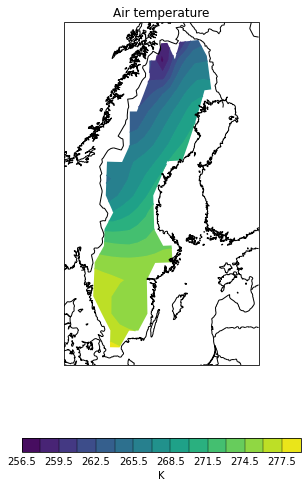

In [17]:
fig, ax = plt.subplots(figsize=(5, 9), subplot_kw={"projection": proj})
qplt.contourf(cube_swe[3000, :, :], 15, axes=ax)
ax.add_feature(cfeature.BORDERS)
ax.coastlines();

## Reference period
Create a climatology of the first 30 years of the data.
This is where the model data come into play.
Ideally we should have a large ensemble of different realisations of the historical climate.
Then we can pool it all into a "reference climate" distribution.

In [117]:
# First we extract the period with a constraint.
ref_time_constraint = iris.Constraint(time=lambda cell: 1970 <= cell.point.year <= 2000)

In [118]:
# Extract the data.
ssp119_cubes_ref = ssp119_cubes.extract(ref_time_constraint)

In [119]:
# Did it work?
print(ssp119_cubes_ref.coord("time"))

DimCoord :  time / (days since 1860-01-01 00:00:00, proleptic_gregorian calendar)
    points: [
        1970-01-01 12:00:00, 1970-01-02 12:00:00, ...,
        2000-12-30 12:00:00, 2000-12-31 12:00:00]
    bounds: [
        [1970-01-01 00:00:00, 1970-01-02 00:00:00],
        [1970-01-02 00:00:00, 1970-01-03 00:00:00],
        ...,
        [2000-12-30 00:00:00, 2000-12-31 00:00:00],
        [2000-12-31 00:00:00, 2001-01-01 00:00:00]]
    shape: (11323,)  bounds(11323, 2)
    dtype: float64
    standard_name: 'time'
    long_name: 'time'
    var_name: 'time'


### Temperature distributions for ensemble
Lets look at the temperature distributions over the summer for the ensemble.

Firstly we want to create average days from the reference period.

In [121]:
ssp119_cubes_ref

Air Temperature (K),realization,time,latitude,longitude
Shape,49,11323,28,55
Dimension coordinates,,,,
realization,x,-,-,-
time,-,x,-,-
latitude,-,-,x,-
longitude,-,-,-,x
Auxiliary coordinates,,,,
MJJA,-,x,-,-
day_of_month,-,x,-,-
month,-,x,-,-


In [122]:
ssp119_cubes_ref = ssp119_cubes_ref.extract(iris.Constraint(MJJA=True))

In [123]:
# By aggregating by the month and day of month
# on all days from 1970 to 2000. Gives a climatology.
# Also for extended summer only since we already selected days in MJJA.
clim_mjja_day_mean = ssp119_cubes_ref.aggregated_by(["month", "day_of_month"], iris.analysis.MEAN)

In [124]:
clim_mjja_day_mean

Air Temperature (K),realization,time,latitude,longitude
Shape,49,123,28,55
Dimension coordinates,,,,
realization,x,-,-,-
time,-,x,-,-
latitude,-,-,x,-
longitude,-,-,-,x
Auxiliary coordinates,,,,
MJJA,-,x,-,-
day_of_month,-,x,-,-
month,-,x,-,-


Now we mask the data for Sweden.

In [130]:
mask = mask_from_shape(clim_mjja_day_mean[1, :, :, :], swe_mainland)

In [132]:
clim_mjja_day_mean.shape

(49, 123, 28, 55)

In [133]:
mask.shape

(123, 28, 55)

In [134]:
mask = np.broadcast_to(mask, clim_mjja_day_mean.shape)

In [135]:
mask.shape

(49, 123, 28, 55)

In [136]:
# This will modify the cube in place as well.
iris.util.mask_cube(clim_mjja_day_mean, mask)

Air Temperature (K),realization,time,latitude,longitude
Shape,49,123,28,55
Dimension coordinates,,,,
realization,x,-,-,-
time,-,x,-,-
latitude,-,-,x,-
longitude,-,-,-,x
Auxiliary coordinates,,,,
MJJA,-,x,-,-
day_of_month,-,x,-,-
month,-,x,-,-


Summer 2018

In [141]:
# Ok, start with one year and go from there.
sm_18 = ssp119_cubes.extract(iris.Constraint(time=lambda cell: cell.point.year == 2018,
                                             MJJA=True
                                            )
                            )

In [145]:
iris.util.mask_cube(sm_18, mask)

Air Temperature (K),realization,time,latitude,longitude
Shape,49,123,28,55
Dimension coordinates,,,,
realization,x,-,-,-
time,-,x,-,-
latitude,-,-,x,-
longitude,-,-,-,x
Auxiliary coordinates,,,,
MJJA,-,x,-,-
day_of_month,-,x,-,-
month,-,x,-,-


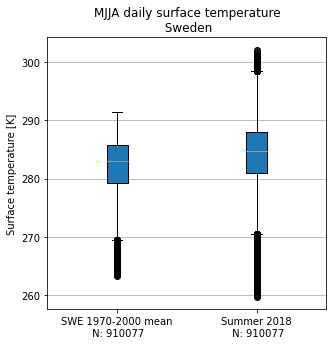

2022-06-27 15:38:13,148 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:13,153 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:13,269 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:13,406 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:13,525 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:13,533 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:13,744 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:13,752 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:14,165 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:14,167 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:14,242 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:14,328 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:14,424 - distributed.nanny - WARNING - Restarting worker
2022-06-27 15:38:14,435 - distributed.

In [159]:
# Create a figure.
fig, ax = plt.subplots(figsize=(5, 5))
# Climatological data.
clim_data = clim_mjja_day_mean.core_data().compressed()
# Summer 18 data, should be observations.
sm_18_data = sm_18.data.compressed()
plt.boxplot([clim_data, sm_18_data],
            labels=[f"SWE 1970-2000 mean\n N: {clim_data.shape[0]}",
                    f"Summer 2018\n N: {sm_18_data.shape[0]}"],
            patch_artist=True,
           );
ax.set_ylabel("Surface temperature [K]")
ax.grid(axis="y")
ax.set_title("MJJA daily surface temperature\n Sweden");

In [147]:
# Percentiles are the inverse of the probability of occurrence.
# E.g. Above 90th percentile has a probability of 10%.
percentile_limit = 90
threshold = np.percentile(sm_18.data.compressed(), percentile_limit)

In [148]:
threshold

290.4613891601563

In [152]:
# We should the count the occurence in the climatology for the same threshold.
nr_events_ref = clim_mjja_day_mean.data.compressed()[clim_mjja_day_mean.data.compressed() >= threshold].shape[0]

In [157]:
nr_events_ref

307

In [153]:
event_prob = nr_events_ref / clim_mjja.data.compressed().shape[0]

In [154]:
event_prob

0.0005332055029586827

Probability ratio of specified event:

In [155]:
# PR
PR = 0.1 / event_prob

In [156]:
PR

187.54495114006517

Fraction attributble risk:

If above 0.5 the risk for the event has doubled.

In [102]:
FAR = 1 - event_prob / (1 - percentile_limit / 100)

In [103]:
FAR

0.7853978112521992

1970 to 2000 is not a great reference period for this. Hmm.
Eventually we want to pool the ensemble I presume.
The problem will always be the reference period.

## Single realisation.

With the selection done we can collapse the time dimension taking a mean.

In [53]:
clim_mjja = clim_cube.extract(iris.Constraint(season_membership=True))

In [54]:
print(clim_mjja.coord("time"))

DimCoord :  time / (days since 1860-01-01 00:00:00, proleptic_gregorian calendar)
    points: [
        1970-05-01 12:00:00, 1970-05-02 12:00:00, ...,
        2000-08-30 12:00:00, 2000-08-31 12:00:00]
    bounds: [
        [1970-05-01 00:00:00, 1970-05-02 00:00:00],
        [1970-05-02 00:00:00, 1970-05-03 00:00:00],
        ...,
        [2000-08-30 00:00:00, 2000-08-31 00:00:00],
        [2000-08-31 00:00:00, 2000-09-01 00:00:00]]
    shape: (3813,)  bounds(3813, 2)
    dtype: float64
    standard_name: 'time'
    long_name: 'time'
    var_name: 'time'


In [55]:
swe_mjja_mean = clim_mjja.collapsed("time", iris.analysis.MEAN)

/home/sm_erhol/.conda/envs/erhol/lib/python3.9/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/sm_erhol/.conda/envs/erhol/lib/python3.9/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_month'.
  warnings.warn(msg.format(self.name()))
/home/sm_erhol/.conda/envs/erhol/lib/python3.9/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_year'.
  warnings.warn(msg.format(self.name()))
/home/sm_erhol/.conda/envs/erhol/lib/python3.9/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'season_membership'.
  warnings.warn(msg.format(self.name()))
/home/sm_erhol/.conda/envs/erhol/lib/python3.9/site-packages/iris/co

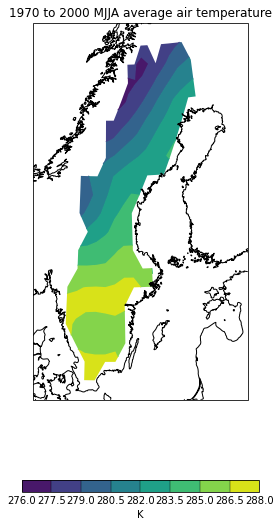

In [56]:
fig, ax = plt.subplots(figsize=(4, 8),
                       subplot_kw={"projection": proj}
                      )
# Show the data.
qplt.contourf(swe_mjja_mean, axes=ax)
# Add coastlines
ax.coastlines()
ax.set_title("1970 to 2000 MJJA average air temperature");
plt.tight_layout()

## Anomalies
We can now compare any summer to the reference climate.
- **This should really be a gridded observation and not from the model.**
    - Complications: Need to regrid model to the resolution of the observation.

In [140]:
cube_swe

Air Temperature (K),time,latitude,longitude
Shape,47847,28,55
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
day_of_month,x,-,-
day_of_year,x,-,-
month,x,-,-
season_membership,x,-,-


In [139]:
# Ok, start with one year and go from there.
sm_18 = cube_swe.extract(iris.Constraint(time=lambda cell: cell.point.year == 2018,
                                         season_membership=True
                                    ))

NameError: name 'year' is not defined

In [58]:
sm_18

Air Temperature (K),time,latitude,longitude
Shape,123,28,55
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
day_of_month,x,-,-
day_of_year,x,-,-
month,x,-,-
season_membership,x,-,-


In [59]:
sm_18_anom = sm_18 - swe_mjja_mean

### Hovmöller of the temp anomalies?
We have to get rid of one spatial dimension either way.
Plot is not needed atm.

### Spatial average of the anomalies

In [60]:
sm_18_anom_mean = sm_18_anom.collapsed("time", iris.analysis.MEAN)

/home/sm_erhol/.conda/envs/erhol/lib/python3.9/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_month'.
  warnings.warn(msg.format(self.name()))
/home/sm_erhol/.conda/envs/erhol/lib/python3.9/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_year'.
  warnings.warn(msg.format(self.name()))
/home/sm_erhol/.conda/envs/erhol/lib/python3.9/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'season_membership'.
  warnings.warn(msg.format(self.name()))
/home/sm_erhol/.conda/envs/erhol/lib/python3.9/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'seasyr'.
  warnings.warn(msg.format(self.name()))
/home/sm_erhol/.conda/envs/erhol/lib/python3.9/site-packages/iris/

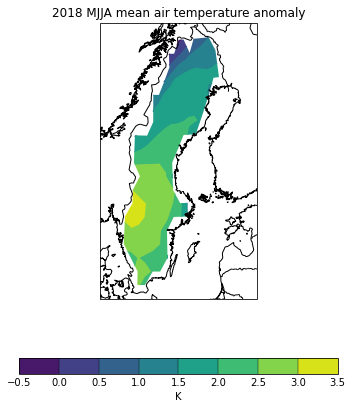

In [61]:
fig, ax = plt.subplots(figsize=(5, 6),
                       subplot_kw={"projection": proj}
                      )
# Show the data.
qplt.contourf(sm_18_anom_mean, axes=ax)
# Add coastlines
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("2018 MJJA mean air temperature anomaly");
plt.tight_layout();

### Temperature distributions
Maps are good, but lets look at the temperature distributions over the summer instead.

Firstly we want to create average days from the reference period.

In [62]:
clim_mjja

Air Temperature (K),time,latitude,longitude
Shape,3813,28,55
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
day_of_month,x,-,-
day_of_year,x,-,-
month,x,-,-
season_membership,x,-,-


In [68]:
# By aggregating by the month and day of month
# on all days from 1970 to 2000. Gives a climatology.
# Also for extended summer only since we already selected days in MJJA.
clim_mjja_day_mean = clim_mjja.aggregated_by(["month", "day_of_month"], iris.analysis.MEAN)

In [69]:
clim_mjja_day_mean

Air Temperature (K),time,latitude,longitude
Shape,123,28,55
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
day_of_month,x,-,-
day_of_year,x,-,-
month,x,-,-
season_membership,x,-,-


In [70]:
# For some reason there is two extra days added here.
# One in the beginning and one in the end.
print(clim_mjja_day_mean.coord("time"))

DimCoord :  time / (days since 1860-01-01 00:00:00, proleptic_gregorian calendar)
    points: [
        1985-05-01 12:00:00, 1985-05-02 12:00:00, ...,
        1985-08-30 12:00:00, 1985-08-31 12:00:00]
    bounds: [
        [1970-05-01 00:00:00, 2000-05-02 00:00:00],
        [1970-05-02 00:00:00, 2000-05-03 00:00:00],
        ...,
        [1970-08-30 00:00:00, 2000-08-31 00:00:00],
        [1970-08-31 00:00:00, 2000-09-01 00:00:00]]
    shape: (123,)  bounds(123, 2)
    dtype: float64
    standard_name: 'time'
    long_name: 'time'
    var_name: 'time'


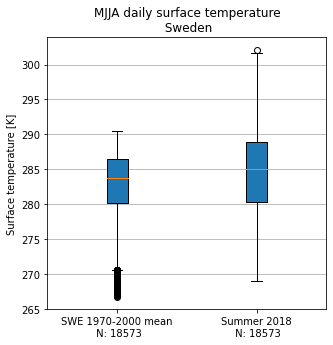

In [71]:
fig, ax = plt.subplots(figsize=(5, 5))
clim_data = clim_mjja_day_mean.core_data().compressed()
sm_18_data = sm_18.data.compressed()
plt.boxplot([clim_data, sm_18_data],
            labels=[f"SWE 1970-2000 mean\n N: {clim_data.shape[0]}",
                    f"Summer 2018\n N: {sm_18_data.shape[0]}"],
            patch_artist=True,
           );
ax.set_ylabel("Surface temperature [K]")
ax.grid(axis="y")
ax.set_title("MJJA daily surface temperature\n Sweden");

In [98]:
# Percentiles are the inverse of the probability of occurrence.
# E.g. Above 90th percentile has a probability of 10%.
percentile_limit = 90
threshold = np.percentile(sm_18.data.compressed(), percentile_limit)

In [90]:
threshold

292.62811279296875

In [91]:
# We should the count the occurence in the climatology for the same threshold.
events = clim_mjja.data.compressed()[clim_mjja.data.compressed() >= threshold].shape[0]

In [158]:
events

12356

In [92]:
event_prob = events / clim_mjja.data.compressed().shape[0]

In [93]:
event_prob

0.021460218874780074

Probability ratio of specified event:

In [94]:
# PR
PR = 0.1 / event_prob

In [ ]:
PR

4.659784719974102

Fraction attributble risk:

If above 0.5 the risk for the event has doubled.

In [102]:
FAR = 1 - event_prob / (1 - percentile_limit / 100)

In [103]:
FAR

0.7853978112521992

1970 to 2000 is not a great reference period for this. Hmm.
Eventually we want to pool the ensemble I presume.
The problem will always be the reference period.